# Navigation

---

In this notebook, we will learn how to use the Unity ML-Agents environment to train an agent to collect yellow bananas and avoid blue bananas.

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37
Episode 100	Average Score: 6.28
Episode 200	Average Score: 10.24
Episode 300	Average Score: 12.94
Episode 302	Average Score: 13.04
Environment solved in 202 episodes!	Average Score: 13.04


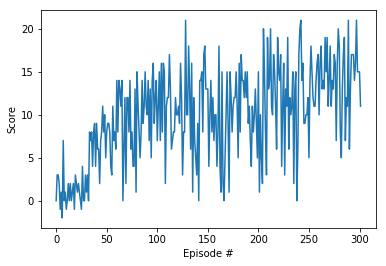

End Score: 19.0


In [1]:
#This code is based on the Lunar Lander code.
# Only a few instructions have been modified to run it on the bananas environment.

#Import required packages
from unityagents import UnityEnvironment
import random
import torch
import numpy as np
from collections import deque
from dqn_agent import Agent
import matplotlib.pyplot as plt
# Set plotting options
from IPython import get_ipython
ipy = get_ipython()
if ipy is not None:
    ipy.run_line_magic('matplotlib', 'inline')

# Avoid warnings concerning deprecated instructions
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

#Set the Unity environment to Bananas. This one is for Mac Os. Change to suite your OS.
env = UnityEnvironment(file_name="Banana.app")

#Get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

#Reset the environment
env_info = env.reset(train_mode=True)[brain_name]

#Number of agents in the environment
print('Number of agents:', len(env_info.agents))

#Number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

#Examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

#Create the Agent

agent = Agent(state_size=state_size, action_size=action_size, seed=0)

#Train the Agent for 2000 episodes the display the average rewards collected

def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.0001, eps_decay=0.01):
    """Deep Q-Learning  (using Lunar Lander model with reduced hidden nodes) 
       Params
       ======
            n_episodes (int): maximum number of training episodes
            max_t (int): maximum number of timesteps per episode
            eps_start (float): starting value of epsilon, for epsilon-greedy action selection
            eps_end (float): minimum value of epsilon
            eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps) # select an action       
            action_info = env.step(vector_action=[action])
            next_state = action_info[brain_name].vector_observations[0]
            reward = action_info[brain_name].rewards[0]
            done = action_info[brain_name].local_done[0]
            max_reach = action_info[brain_name].max_reached[0]            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# Play the Trained Agent

# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth', map_location=lambda storage, loc: storage))

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state)    # select an action 
    #print(action)        
    env_info = env.step(vector_action=[action])    # send the action to the environment                  
    next_state = env_info[brain_name].vector_observations[0]# get the next state 
    reward = env_info[brain_name].rewards[0]       # get the reward
    done = env_info[brain_name].local_done[0]      # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("End Score: {}".format(score))

env.close()